[24ANN] 7조
- 20201588 박태현
- 20201590 송준규
- 20201596 양은주
- 20201610 정하연

# 3. Baseline 학습 및 분석

## 0) Import Modules
Custom utilities (프로젝트 진행 시 계속 필요한 내용들을 따로 정의하여 불러옴.)
- num_of_gpu : 사용할 gpu 개수 지정
- distribute_dataset : 분산학습을 위한 데이터셋 전처리
- set_strategy : 분산학습 위한 모델 정의 과정

In [27]:
# Standard library imports
import os
import time

# Third-party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.python.client import device_lib
import seaborn as sns

# Keras imports
from keras.callbacks import EarlyStopping
from keras.layers import Activation, AveragePooling2D, Conv2D, Dense, Dropout, Flatten, Layer, Input
from keras.models import Sequential
from keras.utils import np_utils
import keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Custom utilities (프로젝트 진행 시 계속 필요한 내용들을 따로 정의하여 불러옴.)
from distribution_utils import num_of_gpu, distribute_dataset, set_strategy
from datasets_utils import prepare_datasets, plot_class_examples, class_counts_plot
from train_and_test_utils import set_before_train, test_loss_and_accuracy, plot_learning_curves

## 1) Multi-gpu 할당

In [3]:
num_gpus = num_of_gpu(num=4)

Number of GPUs: 4


## 2) Prepare the Data

In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test, mapp, num_classes = prepare_datasets('balanced')

X_train shape: (94000, 32, 32, 3)
X_valid shape: (18799, 32, 32, 3)
X_test shape: (18799, 32, 32, 3)
Number of label classes: 47


- EMNIST balanced는 Trainset의 마지막 부분에 Testset과 같은 크기의 Validation set이 있다.
- 분류한 후, .shape을 통해 제대로 분리되었는지 확인하였다.
- 해당 데이터셋이 몇개의 클래스를 가지고 있는지도 확인하였다.

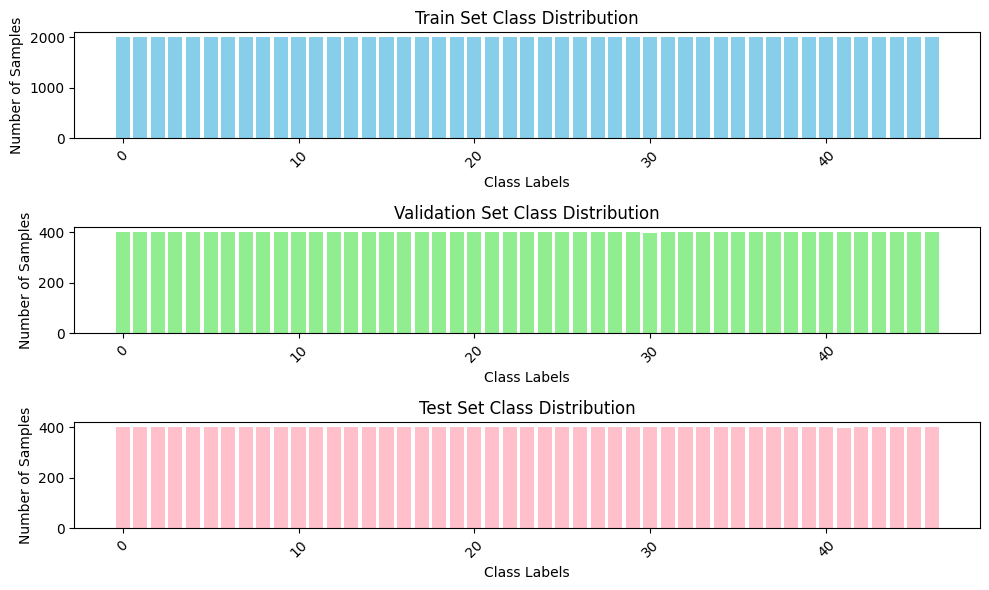

In [5]:
class_counts_plot(y_train, y_valid, y_test)

- Train, (Val,) Test dataset에서 각각 클래스 간 이미지 개수가 동일함을 확인하였다.

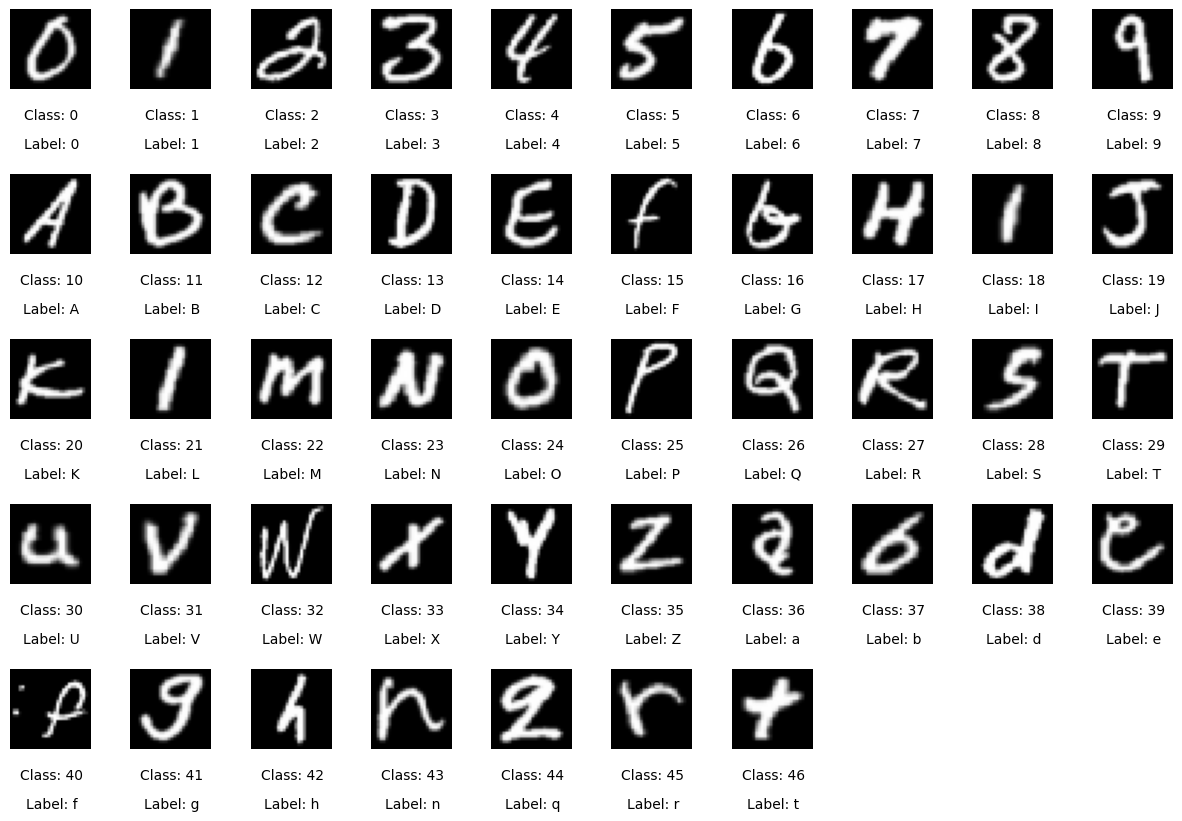

In [5]:
# 클래스별 예시 이미지 출력
plot_class_examples(X_train, y_train, mapp)

## 3) Prepare for Distributed Training

### 3-1) 분산 학습을 위한 설정

In [6]:
strategy = set_strategy()

2024-05-19 23:16:06.482548: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 23:16:08.659192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 22346 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-05-19 23:16:08.660776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 22346 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:22:00.0, compute capability: 8.6
2024-05-19 23:16:08.662297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 22346 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:23:00.0,

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


 Running on multiple GPUs  ['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']


In [7]:
print(strategy)

### 3-3) 분산 데이터셋 설정
- 코드 설명
    - batch_size: **GPU 개수와 배치 사이즈가 지수 관계에 있도록 설정하기 위해, num_gpus를 곱하여 문제가 없도록 하였다.**

    - suffle: 일정한 크기의 데이터가 랜덤 선택되어 버퍼에 임시 저장된 후 섞인다.
        - 너무 작은 버퍼 크기를 사용하면 데이터가 충분히 섞이지 않을 수 있다.
        - 너무 큰 버퍼 크기를 사용하면 메모리를 많이 소비하게 된다.
        - 이 과정에서 **버퍼의 한도를 설정하지 않으면 shuffle하는 시간이 학습 시간보다 오래 걸리는 현상이 발생하여, buffer_size를 10000으로 제한하였다.**

    - 한 에포크에 몇 step이 실행되는지 len(trainset)과 batch_size에 기반하여 계산하였다.
        - np.ceil: 

    - tf.data.Dataset.from_tensor_slices
        - .shuffle(): 
        - .cache(): 
        - .batch(batch_size): 
        - .repeat(): 
        - .prefetch(tf.data.AUTOTUNE): 

    - strategy.experimental_distribute_dataset()

- 발생하는 **Warning: AUTO sharding policy will apply DATA sharding policy**
    - Sharding: 데이터를 여러 부분으로 분할하는 프로세스

    - tensorflow에서 자동으로 데이터셋을 sharding하는 정책을 적용한다는 메시지가 출력된 것.
    
    - **tensorflow가 자동으로 데이터를 sharding하여 분산 처리하고 있음을 나타내는 것이므로, 계속 진행함.**

In [8]:
batch_size = 512
train_steps_per_epoch, val_steps_per_epoch, \
    train_dist_dataset, val_dist_dataset, test_dist_dataset = distribute_dataset(batch_size, num_gpus, strategy,
                                                                                X_train, y_train,
                                                                                X_valid, y_valid,
                                                                                X_test, y_test)

## 3) LeNet5
- 논문: Gradient-Based Learning Applied to Document Recognition (1998) (https://homl.info/lenet5)

    Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
    -------|-----------------|------|----------|-------------|--------|-----------
    Out   | Fully connected | –    | 10       | –           | –      | RBF
    F6    | Fully connected | –    | 84       | –           | –      | tanh
    C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
    S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
    C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
    S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
    C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
    In    | Input           | 1    | 32 × 32  | –           | –      | –

- LeNet-6는 전체적으로 7개의 레이어로 구성되어있지만, 그 중 Convolution Layer와 Fully Connected Layer만을 고려할 때 5개의 레이어로 구성된다.
    - C1 (1st Layer; Convolution Layer)
    - S2 (2nd Layer; Average Pooling Layer)
    - C3 (3rd Layer; Convolution Layer)
    - S4 (4th Layer; Average Pooling Layer)
    - C5 (5th Layer; Convolution Layer)

    ![image](https://github.com/HayeonJeong/StudyNote/assets/123214386/af3429a7-ade2-47ea-824b-45dc2d7981fb)

- 최근 분류 CNN과 가장 크게 차이나는 점은 '활성화 함수'이다.
    - 요즘은 tanh 대신에 ReLU를 사용하고, RBF 대신에 softmax를 사용한다. (from. 교재)


### 모델 구축

In [9]:
class RBFActivation(Layer):
    def __init__(self, num_classes, **kwargs):
        super(RBFActivation, self).__init__(**kwargs)
        self.num_classes = num_classes

    def build(self, input_shape):
        # 중심점을 위한 가중치 정의 (학습 가능)
        self.centers = self.add_weight(name='centers',
                                       shape=(self.num_classes, input_shape[-1]),
                                       initializer='uniform',
                                       trainable=True)

    def call(self, inputs):
        # 입력과 각 중심점과의 거리를 계산
        c = K.expand_dims(self.centers, axis=0)  # centers를 배치 차원에 맞게 확장
        x = K.expand_dims(inputs, axis=1)       # 입력을 클래스 차원에 맞게 확장
        distances = K.sum(K.square(x - c), axis=-1)  # 유클리드 거리 제곱 계산
        # 지수 함수 적용
        return K.exp(-distances)

    def get_config(self):
        config = super(RBFActivation, self).get_config()
        config.update({
            "num_classes": self.num_classes
        })
        return config

In [10]:
with strategy.scope():
    # LeNet-new 모델 정의
    model_LeNet5_old = Sequential(name="LeNet5-old")

    # 첫 번째 합성곱 층 (6개 필터)
    model_LeNet5_old.add(Conv2D(filters=6, kernel_size=5, strides=1, activation='tanh', input_shape=[28, 28, 3], padding='same'))
    model_LeNet5_old.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))

    # 두 번째 합성곱 층 (16개 필터)
    model_LeNet5_old.add(Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', padding='valid'))
    model_LeNet5_old.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))

    # 세 번째 합성곱 층 (120개 필터)
    model_LeNet5_old.add(Conv2D(filters=120, kernel_size=5, strides=1, activation='tanh', padding='valid'))

    # 완전 연결층
    model_LeNet5_old.add(Flatten())
    model_LeNet5_old.add(Dense(84, activation='tanh'))  # 은닉층
    model_LeNet5_old.add(Dropout(0.5))
    model_LeNet5_old.add(RBFActivation(num_classes))  # 출력층 (EMNIST 클래스 수에 맞게 설정)

    # 모델 컴파일
    model_LeNet5_old.compile(optimizer='adam',
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

# 모델 구조 확인
model_LeNet5_old.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "LeNet5-old"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                        

In [11]:
with strategy.scope():
    # LeNet-new 모델 정의
    model_LeNet5_new = Sequential(name="LeNet5-new")

    # 첫 번째 합성곱 층 (6개 필터)
    model_LeNet5_new.add(Conv2D(filters=6, kernel_size=5, strides=1, activation='relu', input_shape=[28, 28, 3], padding='same'))
    model_LeNet5_new.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))

    # 두 번째 합성곱 층 (16개 필터)
    model_LeNet5_new.add(Conv2D(filters=16, kernel_size=5, strides=1, activation='relu', padding='valid'))
    model_LeNet5_new.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))

    # 세 번째 합성곱 층 (120개 필터)
    model_LeNet5_new.add(Conv2D(filters=120, kernel_size=5, strides=1, activation='relu', padding='valid'))

    # 완전 연결층
    model_LeNet5_new.add(Flatten())
    model_LeNet5_new.add(Dense(84, activation='relu'))  # 은닉층
    model_LeNet5_new.add(Dropout(0.5))
    model_LeNet5_new.add(Dense(num_classes, activation='softmax'))  # 출력층 (EMNIST 클래스 수에 맞게 설정)

    # 모델 컴파일
    model_LeNet5_new.compile(optimizer='adam',
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

# 모델 구조 확인
model_LeNet5_new.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "LeNet5-new"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                        

### 학습

In [7]:
def get_model_path(model_name):
    model_path = "trained_models/" + model_name + ".h5"
    return model_path

In [13]:
model_path_LeNet5_old = get_model_path(model_LeNet5_old.name)
early_stopping, model_checkpoint_cb = set_before_train(10, model_LeNet5_old.name)

with strategy.scope():
    start_time = time.time()
    history_model_LeNet5_old = model_LeNet5_old.fit(train_dist_dataset, 
                               epochs=100, 
                               steps_per_epoch=train_steps_per_epoch,
                               validation_data=val_dist_dataset, 
                               validation_steps=val_steps_per_epoch,
                               callbacks=[early_stopping, model_checkpoint_cb])
    end_time = time.time()

model_LeNet5_old.save(model_path_LeNet5_old)
print("Training time : ", end_time - start_time)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 9 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 9 all-reduces with algorithm = nccl, num_packs = 1


2024-05-19 21:15:49.779601: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2024-05-19 21:15:51.337896: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2024-05-19 21:15:53.084244: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2024-05-19 21:15:55.401450: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2024-05-19 21:15:57.747196: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


182/184 [============================>.] - ETA: 0s - loss: 2.9224 - accuracy: 0.3899

2024-05-19 21:16:04.655899: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: LeNet5-old/assets
184/184 [==============================] - 21s 30ms/step - loss: 2.9149 - accuracy: 0.3913 - val_loss: 2.1646 - val_accuracy: 0.5642
Epoch 2/100
184/184 [==============================] - 4s 19ms/step - loss: 1.8362 - accuracy: 0.5934 - val_loss: 1.3655 - val_accuracy: 0.6877
Epoch 3/100
184/184 [==============================] - 4s 19ms/step - loss: 1.3529 - accuracy: 0.6751 - val_loss: 1.0917 - val_accuracy: 0.7228
Epoch 4/100
184/184 [==============================] - 4s 20ms/step - loss: 1.1542 - accuracy: 0.7059 - val_loss: 0.9506 - val_accuracy: 0.7409
Epoch 5/100
184/184 [==============================] - 4s 21ms/step - loss: 1.0530 - accuracy: 0.7177 - val_loss: 0.8411 - val_accuracy: 0.7582
Epoch 6/100
184/184 [==============================] - 4s 20ms/step - loss: 0.9780 - accuracy: 0.7321 - val_loss: 0.7708 - val_accuracy: 0.7798
Epoch 7/100
184/184 [==============================] - 4s 19ms/step - loss: 0.9095 - accuracy:

In [14]:
model_path_LeNet5_new = get_model_path(model_LeNet5_new.name)
early_stopping, model_checkpoint_cb = set_before_train(10, model_LeNet5_new.name)

with strategy.scope():
    start_time = time.time()
    history_model_LeNet5_new = model_LeNet5_new.fit(train_dist_dataset, 
                               epochs=100, 
                               steps_per_epoch=train_steps_per_epoch,
                               validation_data=val_dist_dataset, 
                               validation_steps=val_steps_per_epoch,
                               callbacks=[early_stopping, model_checkpoint_cb])
    end_time = time.time()

model_LeNet5_new.save(model_path_LeNet5_new)
print("Training time : ", end_time - start_time)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
184/184 [==============================] - 9s 27ms/step - loss: 2.6495 - accuracy: 0.2900 - val_loss: 1.2784 - val_accuracy: 0.6474
Epoch 2/100
184/184 [==============================] - 4s 20ms/step - loss: 1.4096 - accuracy: 0.5828 - val_loss: 0.8428 - val_accuracy: 0.7329
Epoch 3/100
184/184 [==============================] - 3s 19ms/step - loss: 1.0910 - accuracy: 0.6698 - val_loss: 0.6886 - val_accuracy: 0.7798
Epoch 4/100
184/184 [==============================] - 4s 19ms/step - loss: 0.9438 - accuracy: 0.7089 - val_loss: 0.6516 - val_accuracy: 0.7836
Epoch 5/100
184/184 [==============================] - 3s 19ms/step - loss: 0.8491 - accuracy: 0.7342 - val_loss: 0.5692 - val_accuracy: 0.8104
Epoch 6/100
184/184 [==============================] - 3s 19ms/step - loss: 0.7682 - accuracy: 0.7553 - val_

### Learning Curve 확인

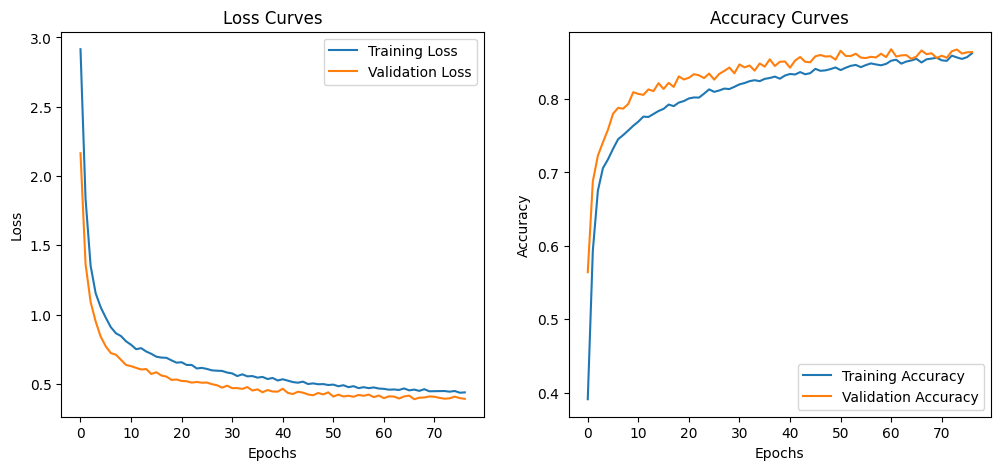

In [16]:
plot_learning_curves(history_model_LeNet5_old)

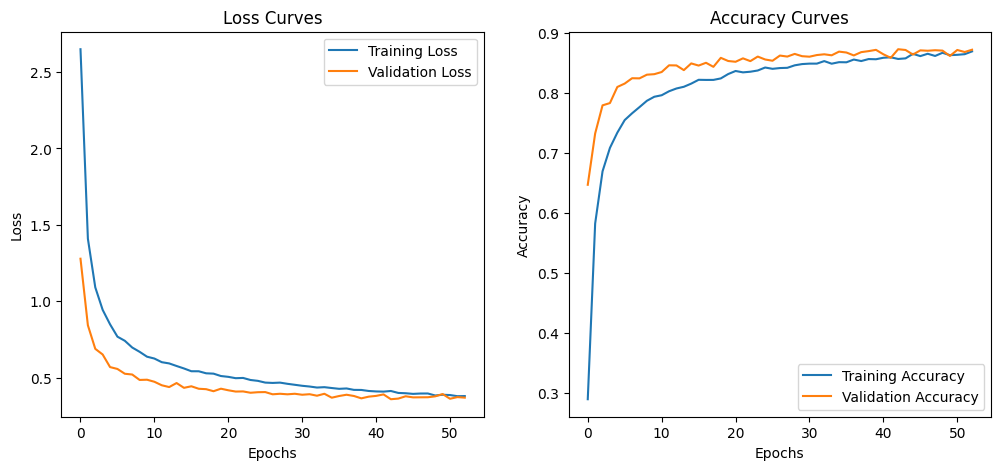

In [17]:
plot_learning_curves(history_model_LeNet5_new)

### Testset으로 성능 평가

In [18]:
# 테스트 데이터셋의 샘플 수
test_samples = len(X_test)

# 배치 크기와 GPU 수를 곱하여 총 배치 크기를 계산합니다.
total_batch_size = batch_size * num_gpus

# 단계 수 계산
test_steps = test_samples // total_batch_size

model = tf.keras.models.load_model(model_path_LeNet5_old, custom_objects={"RBFActivation": RBFActivation})

# 테스트 데이터셋을 사용하여 모델 평가
test_loss, test_accuracy = model_LeNet5_old.evaluate(test_dist_dataset, steps=test_steps)

# 소수점 아래 셋째 자리까지 반올림하여 출력
test_loss_rounded = round(test_loss, 3)
test_accuracy_rounded = round(test_accuracy, 3)

# 반올림된 값 출력
print("Model Name: ", model_LeNet5_old.name)
print("Test Loss: {:.3f}".format(test_loss_rounded))
print("Test Accuracy: {:.3f}".format(test_accuracy_rounded))

9/9 [==============================] - 0s 7ms/step - loss: 0.4227 - accuracy: 0.8611
Model Name:  LeNet5-old
Test Loss: 0.423
Test Accuracy: 0.861


In [19]:
# 테스트 데이터셋의 샘플 수
test_samples = len(X_test)
total_batch_size = batch_size * num_gpus
test_steps = test_samples // total_batch_size
model = tf.keras.models.load_model(model_path_LeNet5_new)
test_loss, test_accuracy = model_LeNet5_new.evaluate(test_dist_dataset, steps=test_steps)
test_loss_rounded = round(test_loss, 3)
test_accuracy_rounded = round(test_accuracy, 3)
print("Model Name: ", model_LeNet5_new.name)
print("Test Loss: {:.3f}".format(test_loss_rounded))
print("Test Accuracy: {:.3f}".format(test_accuracy_rounded))

9/9 [==============================] - 0s 7ms/step - loss: 0.4200 - accuracy: 0.8689
Model Name:  LeNet5-new
Test Loss: 0.420
Test Accuracy: 0.869


In [ ]:
# Perform predictions on X_test using the model
predictions = model_path_LeNet5_old.predict(X_test)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix based on true and predicted labels
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 6})  # Adjust text size
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('Confusion_Matrix/' + str(model_path_LeNet5_old.name) + '.png')  # Save as a file
plt.show()

In [ ]:
# Perform predictions on X_test using the model
predictions = model_path_LeNet5_new.predict(X_test)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix based on true and predicted labels
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 6})  # Adjust text size
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('Confusion_Matrix/' + str(model_path_LeNet5_new.name) + '.png')  # Save as a file
plt.show()

## 2) ResNet-50

![image](https://github.com/HayeonJeong/StudyNote/assets/123214386/2a00af02-1cfa-4012-b7f9-00f378fd7b15)

### 2-1) tf.keras.applications.resnet50.ResNet50
### 이미지를 32*32로 upscaling

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 데이터셋 하나 표시 (크기 변환 확인용)
def display_image(image, title=None):
    print(f"Image shape: {image.shape}")  # 이미지 크기 출력
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [9]:
X_train, y_train, X_valid, y_valid, X_test, y_test, mapp, num_classes = prepare_datasets('balanced')

X_train shape: (94000, 32, 32, 3)
X_valid shape: (18799, 32, 32, 3)
X_test shape: (18799, 32, 32, 3)
Number of label classes: 47


In [10]:
X_valid[0][15]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.00392157, 0.00392157, 0.00392157],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.17254902, 0.17254902, 0.17254902],
       [0.73333335, 0.73333335, 0.73333335],
       [0.9843137 , 0.9843137 , 0.9843137 ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [0.8235294 , 0.8235294 , 0.8235294 ],
       [0.6666667 , 0.6666667 , 0.6666667 ],
       [0.84705883, 0.84705883, 0.84705883],
       [0.9372549 , 0.9372549 , 0.9372549 ],
       [0.9882353 , 0.9882353 , 0.9882353 ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [0.99607843, 0.99607843, 0.99607843],
       [1.        , 1.        , 1.        ],
       [1.

Image shape: (32, 32, 3)


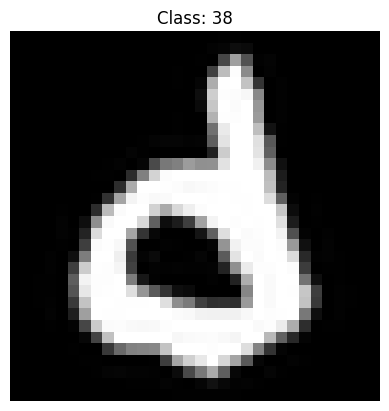

In [11]:
# Display the first image in X_valid
display_image(X_valid[0], title=f"Class: {y_valid[0]}")

In [12]:
X_train, y_train, X_valid, y_valid, X_test, y_test, mapp, num_classes = prepare_datasets('balanced', resize_shape=(32, 32))

X_train shape: (94000, 32, 32, 3)
X_valid shape: (18799, 32, 32, 3)
X_test shape: (18799, 32, 32, 3)
Number of label classes: 47


In [13]:
X_valid[0][15]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.00392157, 0.00392157, 0.00392157],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.17254902, 0.17254902, 0.17254902],
       [0.73333335, 0.73333335, 0.73333335],
       [0.9843137 , 0.9843137 , 0.9843137 ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [0.8235294 , 0.8235294 , 0.8235294 ],
       [0.6666667 , 0.6666667 , 0.6666667 ],
       [0.84705883, 0.84705883, 0.84705883],
       [0.9372549 , 0.9372549 , 0.9372549 ],
       [0.9882353 , 0.9882353 , 0.9882353 ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [0.99607843, 0.99607843, 0.99607843],
       [1.        , 1.        , 1.        ],
       [1.

Image shape: (32, 32, 3)


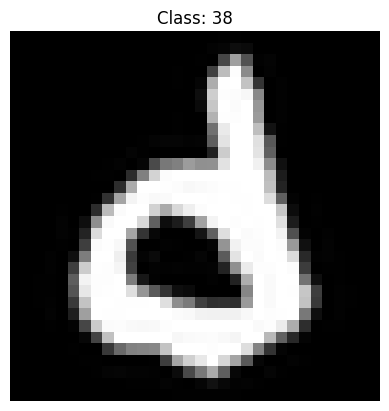

In [14]:
import matplotlib.pyplot as plt

# Display one image from X_valid
def display_image(image, title=None):
    print(f"Image shape: {image.shape}")  # 이미지 크기 출력
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Display the first image in X_valid
display_image(X_valid[0], title=f"Class: {y_valid[0]}")

In [15]:
# 배치 사이즈
batch_size = 512

# Distribute datasets
train_steps_per_epoch, val_steps_per_epoch, \
    train_dist_dataset, val_dist_dataset, test_dist_dataset = distribute_dataset(batch_size, num_gpus, strategy,
                                                                                X_train, y_train,
                                                                                X_valid, y_valid,
                                                                                X_test, y_test)

### tf.keras.applications.resnet50.ResNet50 사용 - 학습

- include_top: 이 매개변수는 네트워크의 최상단에 완전 연결층(fully-connected layer)을 포함할지 여부를 결정합니다. True로 설정하면, 모델의 최상단에 클래스 분류를 위한 완전 연결층이 추가되며, 입력 이미지 크기는 (224, 224, 3)이어야 합니다. False로 설정하면, 이 완전 연결층이 포함되지 않으며, 사용자가 원하는 다양한 크기의 입력을 사용할 수 있습니다(단, 최소 32x32 크기 이상).

- weights: 이 매개변수는 모델의 가중치를 초기화하는 방법을 결정합니다. None을 선택하면 무작위 초기화가 이루어지고, "imagenet"을 선택하면 ImageNet 데이터에 사전 훈련된 가중치를 사용합니다. 가중치 파일의 경로를 문자열로 제공할 수도 있어, 사용자가 특정 파일에서 가중치를 불러올 수 있습니다.

- input_tensor: 이 매개변수는 모델의 입력으로 사용할 선택적 Keras 텐서를 지정합니다. 이는 tf.keras.layers.Input()의 출력 등 다른 레이어의 출력을 직접 모델 입력으로 사용할 때 유용합니다.

- input_shape: include_top이 False일 때만 지정할 수 있는 입력 형태입니다. 이는 모델이 받을 입력의 형태를 정의하며, 채널 수는 반드시 3개여야 하고, 너비와 높이는 최소 32 이상이어야 합니다. 예를 들어, (200, 200, 3)은 유효한 값입니다.

- pooling: include_top이 False일 경우 선택할 수 있는 풀링 모드로, 특징 추출을 위해 사용됩니다. None은 모델의 마지막 컨볼루션 블록 출력을 그대로 사용하며, avg는 글로벌 평균 풀링을 적용하고, max는 글로벌 최대 풀링을 적용합니다. 이는 모델의 출력을 2D 텐서로 변경합니다.

- classes: include_top이 True이고 weights가 지정되지 않았을 때만 지정할 수 있습니다. 이는 이미지를 분류할 클래스의 수를 정의합니다. 예를 들어, 1000개의 다른 카테고리로 이미지를 분류하려면 이 값을 1000으로 설정합니다.

- classifier_activation: 최상단 레이어의 활성화 함수를 설정합니다. include_top=True일 때만 이 매개변수가 의미가 있습니다. None을 설정하면 "로짓"(softmax 전의 출력)을 반환하고, "softmax"를 설정하면 softmax 활성화 함수를 적용합니다. 사전 훈련된 가중치를 사용하는 경우, 이 매개변수는 None 또는 "softmax"로만 설정할 수 있습니다.
    - 학습할 때는 from_logits=True를 사용하여 로짓을 사용하고,
    - 추론할 때는 activation='softmax'를 통해 소프트맥스 활성화 함수를 사용합니다.

In [16]:
with strategy.scope():
    model_ResNet50 = tf.keras.applications.resnet50.ResNet50(include_top=True, weights=None, input_shape=(32, 32, 3), pooling=max, classes=num_classes)

    model_ResNet50.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_ResNet50.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

- SavedModel 형식: 기본적으로 TensorFlow Keras의 model.save 메서드는 SavedModel 형식으로 저장됩니다. 이는 디렉토리 구조로 저장되며, 다양한 TensorFlow 서버 및 플랫폼에서 사용할 수 있음.
- HDF5 형식 (.h5): 단일 파일에 모델 구조, 가중치, 학습 구성 등을 저장할 수 있는 형식.
- 체크포인트 형식 (.ckpt): 주로 가중치와 옵티마이저 상태를 저장하는 데 사용.

In [17]:
#plot_model(model_ResNet50, to_file='model_ResNet50.png', show_shapes=True)

In [18]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1


2024-05-19 23:18:05.921597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2024-05-19 23:18:07.438101: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2024-05-19 23:18:09.190665: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2024-05-19 23:18:12.005217: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2024-05-19 23:18:15.122180: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


184/184 [==============================] - ETA: 0s - loss: 2.0721 - accuracy: 0.4979

2024-05-19 23:18:50.399311: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: resnet50/assets
184/184 [==============================] - 121s 266ms/step - loss: 2.0721 - accuracy: 0.4979 - val_loss: 6.3390 - val_accuracy: 0.0230
Epoch 2/200
184/184 [==============================] - 44s 241ms/step - loss: 0.8580 - accuracy: 0.7361 - val_loss: 5.7192 - val_accuracy: 0.1195
Epoch 3/200
184/184 [==============================] - 44s 241ms/step - loss: 0.7271 - accuracy: 0.7774 - val_loss: 0.9177 - val_accuracy: 0.7090
Epoch 4/200
184/184 [==============================] - 22s 119ms/step - loss: 0.7502 - accuracy: 0.7776 - val_loss: 1.5694 - val_accuracy: 0.6362
Epoch 5/200
184/184 [==============================] - 44s 242ms/step - loss: 0.6893 - accuracy: 0.8021 - val_loss: 0.7753 - val_accuracy: 0.7686
Epoch 6/200
184/184 [==============================] - 21s 113ms/step - loss: 0.5824 - accuracy: 0.8215 - val_loss: 1.3323 - val_accuracy: 0.6744
Epoch 7/200
184/184 [==============================] - 44s 242ms/step - loss: 0.5596

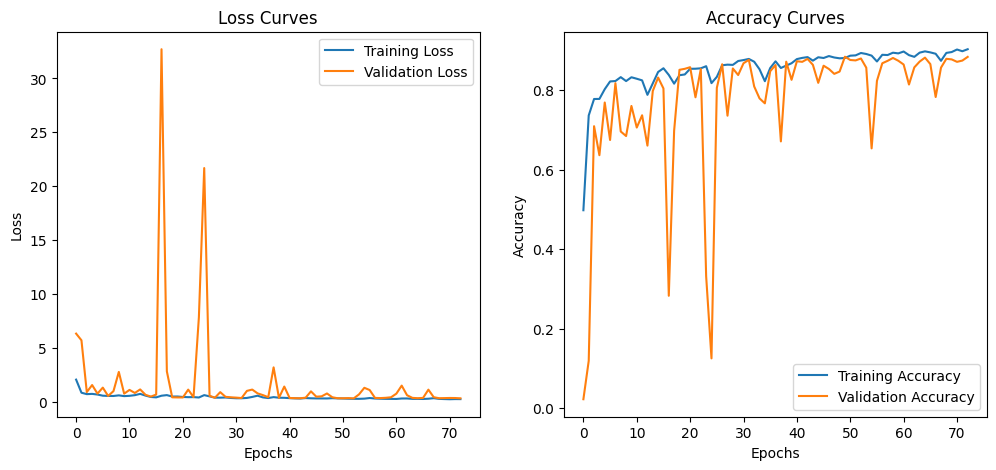

9/9 [==============================] - 1s 34ms/step - loss: 0.3555 - accuracy: 0.8793
Model Name:  resnet50
Test Loss: 0.355
Test Accuracy: 0.879


In [19]:
# 학습
model_path_model_ResNet50 = get_model_path(model_ResNet50.name)
early_stopping, model_checkpoint_cb = set_before_train(20, model_ResNet50.name)

with strategy.scope():
    start_time = time.time()
    history_model_ResNet50 = model_ResNet50.fit(train_dist_dataset, 
                               epochs=200, 
                               steps_per_epoch=train_steps_per_epoch,
                               validation_data=val_dist_dataset, 
                               validation_steps=val_steps_per_epoch,
                               callbacks=[early_stopping, model_checkpoint_cb])
    end_time = time.time()

model_ResNet50.save(model_path_model_ResNet50)
print("Training time : ", end_time - start_time)

# learning curve
plot_learning_curves(history_model_ResNet50)

# 테스트셋으로 성능 평가
# test_samples = len(X_test)
# total_batch_size = batch_size * num_gpus
# test_steps = test_samples // total_batch_size
# model = tf.keras.models.load_model(model_path_model_ResNet50)
# test_loss, test_accuracy = model_ResNet50.evaluate(test_dist_dataset, steps=test_steps)
# test_loss_rounded = round(test_loss, 3)
# test_accuracy_rounded = round(test_accuracy, 3)
# print("Model Name: ", model_ResNet50.name)
# print("Test Loss: {:.3f}".format(test_loss_rounded))
# print("Test Accuracy: {:.3f}".format(test_accuracy_rounded))
test_loss_and_accuracy(model_ResNet50, X_test, batch_size, num_gpus, test_dist_dataset, custom_objects=None)

### tf.keras.applications.resnet50.ResNet50 사용 - 추가 성능 평가

In [20]:
from sklearn.metrics import classification_report

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_classes))

In [21]:
evaluate_model(model_ResNet50, X_test, y_test)

2024-05-19 23:49:53.180712: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_839965"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1163"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       400
           1       0.55      0.66      0.60       400
           2       0.94      0.88      0.91       400
           3       0.99      0.97      0.98       400
           4       0.92      0.94      0.93       400
           5       0.94      0.91      0.92       400
           6       0.96      0.92      0.94       400
           7       0.98      0.98      0.98       400
           8       0.98      0.84      0.91       400
           9       0.69      0.81      0.75       400
          10       0.96      0.94      0.95       400
          11       0.95      0.95      0.95       400
          12       0.94      0.97      0.95       400
          13       0.93      0.91      0.92       400
          14       0.98      0.97      0.97       400
          15       0.77      0.44      0.56       400
          16       0.94      0.95      0.95       400
    

2024-05-19 23:50:17.254800: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_848370"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1196"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

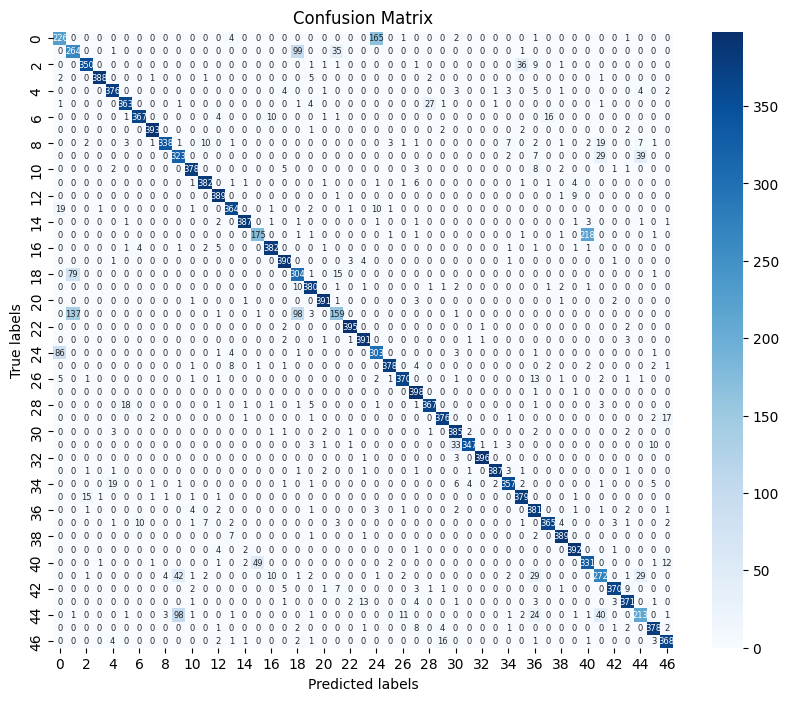

In [22]:
# Perform predictions on X_test using the model
predictions = model_ResNet50.predict(X_test)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix based on true and predicted labels
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 6})  # Adjust text size
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('Confusion_Matrix/' + str(model_ResNet50.name) + '.png')  # Save as a file
plt.show()

### 2-2) ResNet 모델 구현 및 학습
[ 바꿔볼 수 있는 것들 ]
1. 배치 사이즈 변경

2. 활성화 함수 변경: LeakyReLU, PReLU, ELU 등

3. regularization 추가: dropout, l2 regularization

4. Learning Rate Scheduler: 학습률을 동적으로 조정하기

5. 데이터 증강(data augmentation)
    - confusion matrix 확인 후, 부족한 부분의 데이터셋을 더 보충해보기

6. optimizer 변경: Adam, SGD with momentum, RMSprop

7. batchnormalization 추가

8. 네트워크 깊이 및 폭 변경: resnet의 블록 수 변경, 각 블록의 필터 수 변경

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Resizing, Dense, LeakyReLU
from tensorflow.keras import layers
import tensorflow as tf

# reference : https://velog.io/@astron8t/ResNet-50-%EB%AA%A8%EB%8D%B8-%EA%B5%AC%ED%98%84

def first_convolution(x):
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(x)
    x = BatchNormalization(name='conv1_bn')(x)
    x = Activation('relu')(x)
    return x

def first_pooling(x):
    return MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

def residual_block(input_tensor, kernel_size, filters, stage, block, use_leaky_relu=False):
    filters1, filters2, filters3 = filters

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = LeakyReLU(alpha=0.1)(x) if use_leaky_relu else Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = LeakyReLU(alpha=0.1)(x) if use_leaky_relu else Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = LeakyReLU(alpha=0.1)(x) if use_leaky_relu else Activation('relu')(x)
    return x

def downsize_block(input_tensor, kernel_size, strides, filters, stage, block, use_leaky_relu=False):
    filters1, filters2, filters3 = filters

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = LeakyReLU(alpha=0.1)(x) if use_leaky_relu else Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = LeakyReLU(alpha=0.1)(x) if use_leaky_relu else Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.1)(x) if use_leaky_relu else Activation('relu')(x)
    return x

#### 1. 배치 사이즈 키우기 (256 -> 2048)

In [29]:
from distribution_utils import num_of_gpu, distribute_dataset, set_strategy

# 배치 사이즈
batch_size = 2048

# Distribute datasets
train_steps_per_epoch, val_steps_per_epoch, \
    train_dist_dataset, val_dist_dataset, test_dist_dataset = distribute_dataset(batch_size, num_gpus, strategy,
                                                                                X_train, y_train,
                                                                                X_valid, y_valid,
                                                                                X_test, y_test)

In [30]:
# 모델 정의
with strategy.scope():
    input_tensor = Input(shape=(32, 32, 3))
    x = Resizing(224, 224, interpolation='bilinear')(input_tensor)  # Resize input images to 224x224x3
    #x = data_augmentation(x)

    # 첫번째 stage, convolution 수행, strides = 2 로 하여 크기를 반으로
    x = first_convolution(x)

    # 두번째 stage, pooling 을 적용하여 크기를 반으로 줄이고 첫번째 downsize block 에서는 strides = 1 로 함.
    x = first_pooling(x)
    x = downsize_block(x, (3, 3), (1, 1), (64, 64, 256), 2, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'c', use_leaky_relu=False)

    # 세번째 stage, block 의 수는 4개
    x = downsize_block(x, (3, 3), (2, 2), (128, 128, 512), 3, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'c', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'd', use_leaky_relu=False)

    # 네번째 stage, block 의 수는 6개
    x = downsize_block(x, (3, 3), (2, 2), (256, 256, 1024), 4, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'c', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'd', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'e', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'f', use_leaky_relu=False)

    # 다섯번째 stage, block 의 수는 3개
    x = downsize_block(x, (3, 3), (2, 2), (512, 512, 2048), 5, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'c', use_leaky_relu=False)

    # Global Average Pooling 으로 사이즈를 1x1x2048 로 만듦.
    x = GlobalAveragePooling2D()(x)
    #x = Dropout(0.5)(x)  # Dropout 추가
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model_ResNet50 = Model(inputs=input_tensor, outputs=output_tensor)

    model_ResNet50.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_ResNet50.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing_1 (Resizing)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['resizing_1[0][0]']             
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1[0][0]']            

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
46/46 [==============================] - 111s 1s/step - loss: 1.7907 - accuracy: 0.5360 - val_loss: 15.0622 - val_accuracy: 0.0215
Epoch 2/200
46/46 [==============================] - 43s 937ms/step - loss: 0.5457 - accuracy: 0.8177 - val_loss: 12.4059 - val_accuracy: 0.0225
Epoch 3/200
46/46 [==============================] - 44s 970ms/step - loss: 0.4553 - accuracy: 0.8423 - val_loss: 11.3233 - val_accuracy: 0.0215
Epoch 4/200
46/46 [==============================] - 21s 457ms/step - loss: 0.4192 - accuracy: 0.8540 - val_loss: 12.3653 - val_accuracy: 0.0205
Epoch 5/200
46/46 [==============================] - 20s 430ms/step - loss: 0.4129 - accuracy: 0.8587 - val_loss: 12.9023 - val_accuracy: 0.0354
Epoch 6/200
46/46 [==============================] - 20s 431ms/step - loss: 0.3763 - accuracy: 0.8691 -

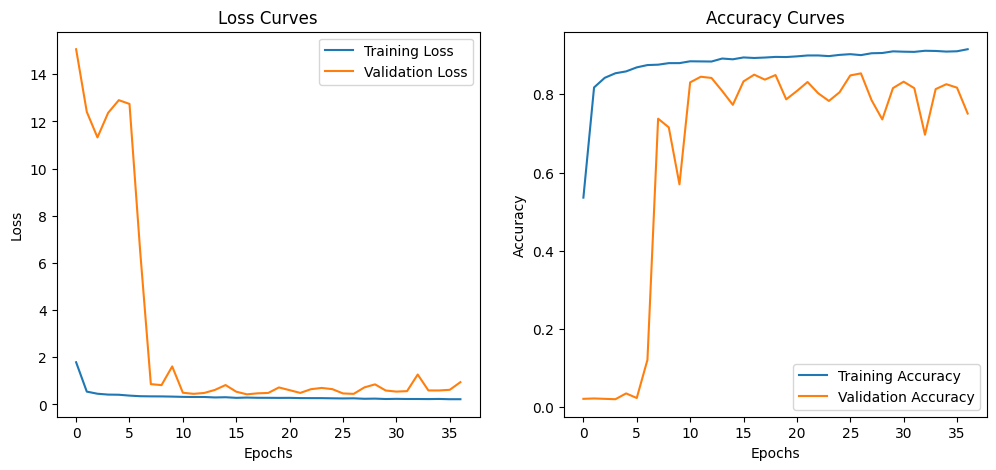

2/2 [==============================] - 1s 112ms/step - loss: 1.0040 - accuracy: 0.7598
Model Name:  model_1
Test Loss: 1.004
Test Accuracy: 0.760


In [31]:
# 학습
model_path_model_ResNet50 = get_model_path(model_ResNet50.name)
early_stopping, model_checkpoint_cb = set_before_train(20, model_ResNet50.name)

with strategy.scope():
    start_time = time.time()
    history_model_ResNet50 = model_ResNet50.fit(train_dist_dataset, 
                               epochs=200, 
                               steps_per_epoch=train_steps_per_epoch,
                               validation_data=val_dist_dataset, 
                               validation_steps=val_steps_per_epoch,
                               callbacks=[early_stopping, model_checkpoint_cb])
    end_time = time.time()

model_ResNet50.save(model_path_model_ResNet50)
print("Training time : ", end_time - start_time)

# learning curve
plot_learning_curves(history_model_ResNet50)

# 테스트셋으로 성능 평가
test_loss_and_accuracy(model_ResNet50, X_test, batch_size, num_gpus, test_dist_dataset, custom_objects=None)

#### 2. Learning Rate Scheduler: 학습률을 동적으로 조정하기

In [34]:
from tensorflow.keras.optimizers import Adam

In [38]:
# 모델 정의
with strategy.scope():
    input_tensor = Input(shape=(32, 32, 3))
    x = Resizing(224, 224, interpolation='bilinear')(input_tensor)  # Resize input images to 224x224x3
    #x = data_augmentation(x)

    # 첫번째 stage, convolution 수행, strides = 2 로 하여 크기를 반으로
    x = first_convolution(x)

    # 두번째 stage, pooling 을 적용하여 크기를 반으로 줄이고 첫번째 downsize block 에서는 strides = 1 로 함.
    x = first_pooling(x)
    x = downsize_block(x, (3, 3), (1, 1), (64, 64, 256), 2, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'c', use_leaky_relu=False)

    # 세번째 stage, block 의 수는 4개
    x = downsize_block(x, (3, 3), (2, 2), (128, 128, 512), 3, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'c', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'd', use_leaky_relu=False)

    # 네번째 stage, block 의 수는 6개
    x = downsize_block(x, (3, 3), (2, 2), (256, 256, 1024), 4, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'c', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'd', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'e', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'f', use_leaky_relu=False)

    # 다섯번째 stage, block 의 수는 3개
    x = downsize_block(x, (3, 3), (2, 2), (512, 512, 2048), 5, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'c', use_leaky_relu=False)

    # Global Average Pooling 으로 사이즈를 1x1x2048 로 만듦.
    x = GlobalAveragePooling2D()(x)
    #x = Dropout(0.5)(x)  # Dropout 추가
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model_ResNet50 = Model(inputs=input_tensor, outputs=output_tensor)

    # 초기 학습률 설정
    initial_learning_rate = 0.0005
    # 모델 컴파일 시 옵티마이저에 학습률 설정
    with strategy.scope():
        model_ResNet50.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])


model_ResNet50.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing_4 (Resizing)          (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['resizing_4[0][0]']             
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1[0][0]']            

일반적으로 ReduceLROnPlateau의 patience 값을 early_stopping의 절반 정도로 설정한다고 하여 patience를 10으로 설정함. 최종 모델 선정 후 변경 필요.

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
46/46 [==============================] - 114s 1s/step - loss: 1.6809 - accuracy: 0.5403 - val_loss: 6.4254 - val_accuracy: 0.0201 - lr: 5.0000e-04
Epoch 2/200
46/46 [==============================] - 20s 429ms/step - loss: 0.5251 - accuracy: 0.8232 - val_loss: 8.8709 - val_accuracy: 0.0213 - lr: 5.0000e-04
Epoch 3/200
46/46 [==============================] - 20s 429ms/step - loss: 0.4366 - accuracy: 0.8507 - val_loss: 10.0827 - val_accuracy: 0.0219 - lr: 5.0000e-04
Epoch 4/200
46/46 [==============================] - 20s 428ms/step - loss: 0.3896 - accuracy: 0.8626 - val_loss: 9.6613 - val_accuracy: 0.0270 - lr: 5.0000e-04
Epoch 5/200
46/46 [==============================] - 20s 434ms/step - loss: 0.3939 - accuracy: 0.8621 - val_loss: 10.2014 - val_accuracy: 0.0250 - lr: 5.0000e-04
Epoch 6/200
46/46 [==

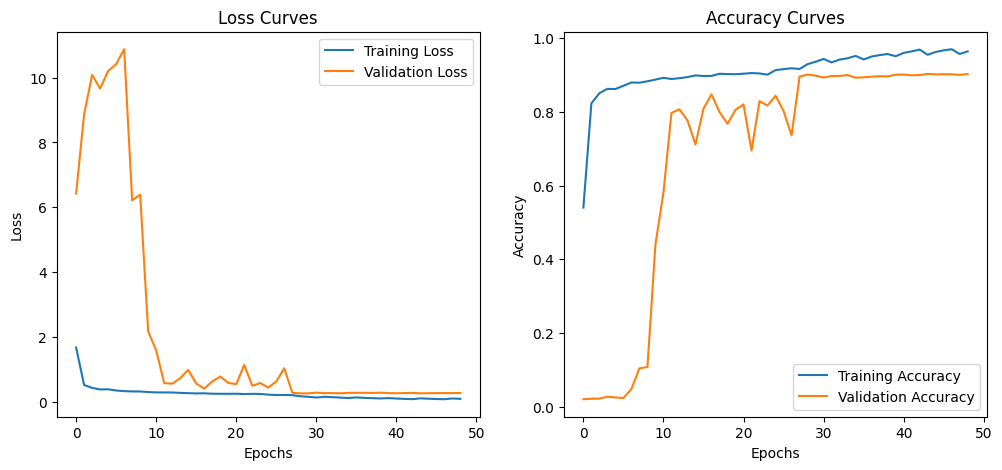

2/2 [==============================] - 1s 113ms/step - loss: 0.3088 - accuracy: 0.9062
Model Name:  model_4
Test Loss: 0.309
Test Accuracy: 0.906


In [39]:
# 학습
model_path_model_ResNet50 = get_model_path(model_ResNet50.name)
early_stopping, model_checkpoint_cb = set_before_train(20, model_ResNet50.name)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # 성능을 모니터링할 지표
    factor=0.1,  # 학습률 감소 비율
    patience=10,  # 성능 향상이 없는 에포크 수
    min_lr=1e-6  # 학습률의 최소 값
)

with strategy.scope():
    start_time = time.time()
    history_model_ResNet50 = model_ResNet50.fit(train_dist_dataset, 
                               epochs=200, 
                               steps_per_epoch=train_steps_per_epoch,
                               validation_data=val_dist_dataset, 
                               validation_steps=val_steps_per_epoch,
                               callbacks=[early_stopping, model_checkpoint_cb, lr_scheduler])
    end_time = time.time()

model_ResNet50.save(model_path_model_ResNet50)
print("Training time : ", end_time - start_time)

# learning curve
plot_learning_curves(history_model_ResNet50)

# 테스트셋으로 성능 평가
test_loss_and_accuracy(model_ResNet50, X_test, batch_size, num_gpus, test_dist_dataset, custom_objects=None)

#### 3. 활성화 함수 변경: LeakyReLU, PReLU, ELU 등

In [42]:
# 모델 정의
with strategy.scope():
    input_tensor = Input(shape=(32, 32, 3))
    x = Resizing(224, 224, interpolation='bilinear')(input_tensor)  # Resize input images to 224x224x3
    #x = data_augmentation(x)

    # 첫번째 stage, convolution 수행, strides = 2 로 하여 크기를 반으로
    x = first_convolution(x)

    # 두번째 stage, pooling 을 적용하여 크기를 반으로 줄이고 첫번째 downsize block 에서는 strides = 1 로 함.
    x = first_pooling(x)
    x = downsize_block(x, (3, 3), (1, 1), (64, 64, 256), 2, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'c', use_leaky_relu=True)

    # 세번째 stage, block 의 수는 4개
    x = downsize_block(x, (3, 3), (2, 2), (128, 128, 512), 3, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'c', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'd', use_leaky_relu=True)

    # 네번째 stage, block 의 수는 6개
    x = downsize_block(x, (3, 3), (2, 2), (256, 256, 1024), 4, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'c', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'd', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'e', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'f', use_leaky_relu=True)

    # 다섯번째 stage, block 의 수는 3개
    x = downsize_block(x, (3, 3), (2, 2), (512, 512, 2048), 5, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'c', use_leaky_relu=True)

    # Global Average Pooling 으로 사이즈를 1x1x2048 로 만듦.
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout 추가
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model_ResNet50 = Model(inputs=input_tensor, outputs=output_tensor)

    # 초기 학습률 설정
    initial_learning_rate = 0.0005
    # 모델 컴파일 시 옵티마이저에 학습률 설정
    with strategy.scope():
        model_ResNet50.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

model_ResNet50.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing_6 (Resizing)          (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['resizing_6[0][0]']             
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1[0][0]']            

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
46/46 [==============================] - 115s 1s/step - loss: 2.0169 - accuracy: 0.4766 - val_loss: 6.0897 - val_accuracy: 0.0234 - lr: 5.0000e-04
Epoch 2/200
46/46 [==============================] - 20s 441ms/step - loss: 0.6675 - accuracy: 0.7840 - val_loss: 6.9799 - val_accuracy: 0.0225 - lr: 5.0000e-04
Epoch 3/200
46/46 [==============================] - 20s 444ms/step - loss: 0.5552 - accuracy: 0.8197 - val_loss: 7.9999 - val_accuracy: 0.0209 - lr: 5.0000e-04
Epoch 4/200
46/46 [==============================] - 20s 443ms/step - loss: 0.4715 - accuracy: 0.8393 - val_loss: 9.2349 - val_accuracy: 0.0215 - lr: 5.0000e-04
Epoch 5/200
46/46 [==============================] - 20s 446ms/step - loss: 0.4590 - accuracy: 0.8434 - val_loss: 11.1517 - val_accuracy: 0.0330 - lr: 5.0000e-04
Epoch 6/200
46/46 [===

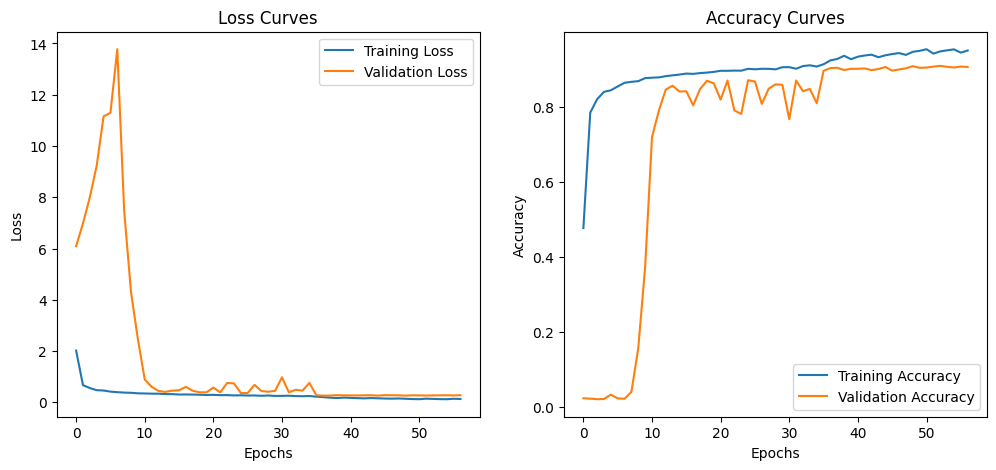

2/2 [==============================] - 1s 136ms/step - loss: 0.3264 - accuracy: 0.9062
Model Name:  model_6
Test Loss: 0.326
Test Accuracy: 0.906


In [43]:
# 학습
model_path_model_ResNet50 = get_model_path(model_ResNet50.name)
early_stopping, model_checkpoint_cb = set_before_train(20, model_ResNet50.name)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # 성능을 모니터링할 지표
    factor=0.1,  # 학습률 감소 비율
    patience=10,  # 성능 향상이 없는 에포크 수
    min_lr=1e-6  # 학습률의 최소 값
)

with strategy.scope():
    start_time = time.time()
    history_model_ResNet50 = model_ResNet50.fit(train_dist_dataset, 
                               epochs=200, 
                               steps_per_epoch=train_steps_per_epoch,
                               validation_data=val_dist_dataset, 
                               validation_steps=val_steps_per_epoch,
                               callbacks=[early_stopping, model_checkpoint_cb, lr_scheduler])
    end_time = time.time()

model_ResNet50.save(model_path_model_ResNet50)
print("Training time : ", end_time - start_time)

# learning curve
plot_learning_curves(history_model_ResNet50)

# 테스트셋으로 성능 평가
test_loss_and_accuracy(model_ResNet50, X_test, batch_size, num_gpus, test_dist_dataset, custom_objects=None)

#### 4. regularization 추가: **dropout**, l2 regularization

In [44]:
# 모델 정의
with strategy.scope():
    input_tensor = Input(shape=(32, 32, 3))
    x = Resizing(224, 224, interpolation='bilinear')(input_tensor)  # Resize input images to 224x224x3
    #x = data_augmentation(x)

    # 첫번째 stage, convolution 수행, strides = 2 로 하여 크기를 반으로
    x = first_convolution(x)

    # 두번째 stage, pooling 을 적용하여 크기를 반으로 줄이고 첫번째 downsize block 에서는 strides = 1 로 함.
    x = first_pooling(x)
    x = downsize_block(x, (3, 3), (1, 1), (64, 64, 256), 2, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'c', use_leaky_relu=True)

    # 세번째 stage, block 의 수는 4개
    x = downsize_block(x, (3, 3), (2, 2), (128, 128, 512), 3, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'c', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'd', use_leaky_relu=True)

    # 네번째 stage, block 의 수는 6개
    x = downsize_block(x, (3, 3), (2, 2), (256, 256, 1024), 4, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'c', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'd', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'e', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'f', use_leaky_relu=True)

    # 다섯번째 stage, block 의 수는 3개
    x = downsize_block(x, (3, 3), (2, 2), (512, 512, 2048), 5, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'c', use_leaky_relu=True)

    # Global Average Pooling 으로 사이즈를 1x1x2048 로 만듦.
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout 추가
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model_ResNet50 = Model(inputs=input_tensor, outputs=output_tensor)

    # 초기 학습률 설정
    initial_learning_rate = 0.0005
    # 모델 컴파일 시 옵티마이저에 학습률 설정
    with strategy.scope():
        model_ResNet50.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

model_ResNet50.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing_7 (Resizing)          (None, 224, 224, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['resizing_7[0][0]']             
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1[0][0]']            

Epoch 1/200
46/46 [==============================] - 117s 1s/step - loss: 2.0322 - accuracy: 0.4691 - val_loss: 6.9619 - val_accuracy: 0.0219 - lr: 5.0000e-04
Epoch 2/200
46/46 [==============================] - 20s 441ms/step - loss: 0.6929 - accuracy: 0.7794 - val_loss: 7.6325 - val_accuracy: 0.0203 - lr: 5.0000e-04
Epoch 3/200
46/46 [==============================] - 44s 969ms/step - loss: 0.5520 - accuracy: 0.8216 - val_loss: 6.8840 - val_accuracy: 0.0223 - lr: 5.0000e-04
Epoch 4/200
46/46 [==============================] - 20s 440ms/step - loss: 0.4927 - accuracy: 0.8341 - val_loss: 8.3935 - val_accuracy: 0.0238 - lr: 5.0000e-04
Epoch 5/200
46/46 [==============================] - 20s 446ms/step - loss: 0.4542 - accuracy: 0.8478 - val_loss: 12.2536 - val_accuracy: 0.0213 - lr: 5.0000e-04
Epoch 6/200
46/46 [==============================] - 21s 449ms/step - loss: 0.4132 - accuracy: 0.8537 - val_loss: 9.7098 - val_accuracy: 0.0209 - lr: 5.0000e-04
Epoch 7/200
46/46 [================

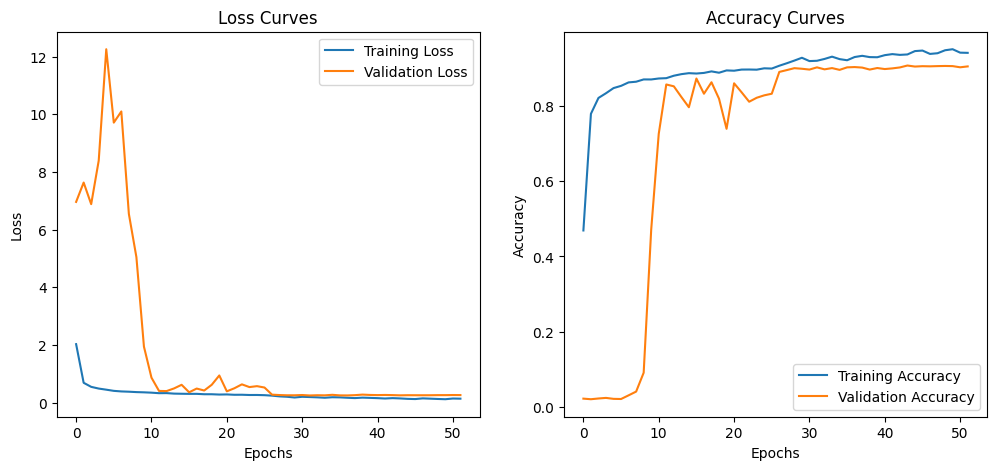

2/2 [==============================] - 1s 136ms/step - loss: 0.3080 - accuracy: 0.9043
Model Name:  model_7
Test Loss: 0.308
Test Accuracy: 0.904


In [45]:
# 학습
model_path_model_ResNet50 = get_model_path(model_ResNet50.name)
early_stopping, model_checkpoint_cb = set_before_train(20, model_ResNet50.name)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # 성능을 모니터링할 지표
    factor=0.1,  # 학습률 감소 비율
    patience=10,  # 성능 향상이 없는 에포크 수
    min_lr=1e-6  # 학습률의 최소 값
)

with strategy.scope():
    start_time = time.time()
    history_model_ResNet50 = model_ResNet50.fit(train_dist_dataset, 
                               epochs=200, 
                               steps_per_epoch=train_steps_per_epoch,
                               validation_data=val_dist_dataset, 
                               validation_steps=val_steps_per_epoch,
                               callbacks=[early_stopping, model_checkpoint_cb, lr_scheduler])
    end_time = time.time()

model_ResNet50.save(model_path_model_ResNet50)
print("Training time : ", end_time - start_time)

# learning curve
plot_learning_curves(history_model_ResNet50)

# 테스트셋으로 성능 평가
test_loss_and_accuracy(model_ResNet50, X_test, batch_size, num_gpus, test_dist_dataset, custom_objects=None)

#### 5. 데이터 증강(data augmentation)

In [46]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [47]:
# 모델 정의
with strategy.scope():
    input_tensor = Input(shape=(32, 32, 3))
    x = Resizing(224, 224, interpolation='bilinear')(input_tensor)  # Resize input images to 224x224x3
    x = data_augmentation(x)

    # 첫번째 stage, convolution 수행, strides = 2 로 하여 크기를 반으로
    x = first_convolution(x)

    # 두번째 stage, pooling 을 적용하여 크기를 반으로 줄이고 첫번째 downsize block 에서는 strides = 1 로 함.
    x = first_pooling(x)
    x = downsize_block(x, (3, 3), (1, 1), (64, 64, 256), 2, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'c', use_leaky_relu=True)

    # 세번째 stage, block 의 수는 4개
    x = downsize_block(x, (3, 3), (2, 2), (128, 128, 512), 3, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'c', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'd', use_leaky_relu=True)

    # 네번째 stage, block 의 수는 6개
    x = downsize_block(x, (3, 3), (2, 2), (256, 256, 1024), 4, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'c', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'd', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'e', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'f', use_leaky_relu=True)

    # 다섯번째 stage, block 의 수는 3개
    x = downsize_block(x, (3, 3), (2, 2), (512, 512, 2048), 5, 'a', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'b', use_leaky_relu=True)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'c', use_leaky_relu=True)

    # Global Average Pooling 으로 사이즈를 1x1x2048 로 만듦.
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout 추가
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model_ResNet50 = Model(inputs=input_tensor, outputs=output_tensor)

    # 초기 학습률 설정
    initial_learning_rate = 0.0005
    # 모델 컴파일 시 옵티마이저에 학습률 설정
    with strategy.scope():
        model_ResNet50.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

model_ResNet50.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing_8 (Resizing)          (None, 224, 224, 3)  0           ['input_10[0][0]']               
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['resizing_8[0][0]']             
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['sequential[0][0]']             
                                )                                                           

Epoch 1/200
46/46 [==============================] - 124s 1s/step - loss: 3.6461 - accuracy: 0.1392 - val_loss: 9.7772 - val_accuracy: 0.0217 - lr: 5.0000e-04
Epoch 2/200
46/46 [==============================] - 23s 494ms/step - loss: 2.0688 - accuracy: 0.3883 - val_loss: 16.9654 - val_accuracy: 0.0223 - lr: 5.0000e-04
Epoch 3/200
46/46 [==============================] - 23s 496ms/step - loss: 1.5171 - accuracy: 0.5393 - val_loss: 16.8752 - val_accuracy: 0.0227 - lr: 5.0000e-04
Epoch 4/200
46/46 [==============================] - 23s 496ms/step - loss: 1.2485 - accuracy: 0.6054 - val_loss: 9.9437 - val_accuracy: 0.0230 - lr: 5.0000e-04
Epoch 5/200
46/46 [==============================] - 23s 499ms/step - loss: 1.1422 - accuracy: 0.6383 - val_loss: 13.4724 - val_accuracy: 0.0217 - lr: 5.0000e-04
Epoch 6/200
46/46 [==============================] - 23s 500ms/step - loss: 1.0247 - accuracy: 0.6715 - val_loss: 10.2246 - val_accuracy: 0.0311 - lr: 5.0000e-04
Epoch 7/200
46/46 [=============

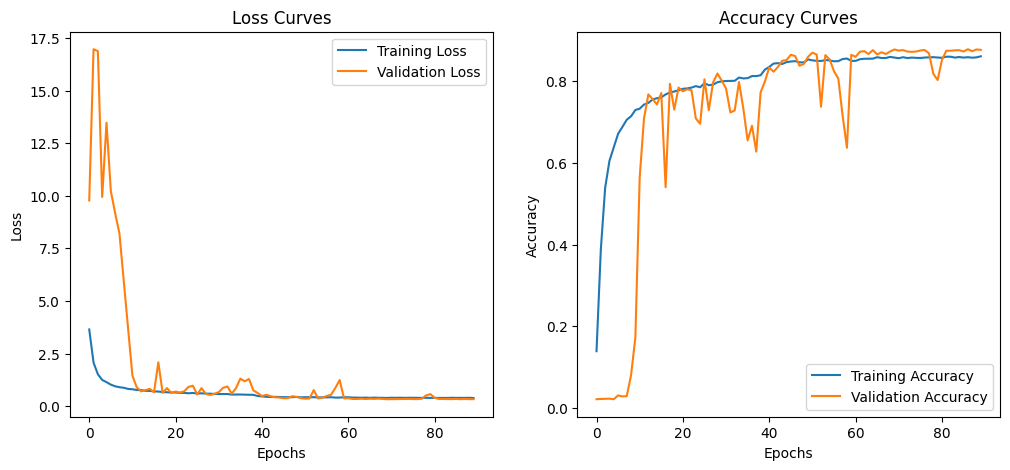

2/2 [==============================] - 1s 135ms/step - loss: 0.3741 - accuracy: 0.8838
Model Name:  model_8
Test Loss: 0.374
Test Accuracy: 0.884


In [48]:
# 학습
model_path_model_ResNet50 = get_model_path(model_ResNet50.name)
early_stopping, model_checkpoint_cb = set_before_train(20, model_ResNet50.name)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # 성능을 모니터링할 지표
    factor=0.1,  # 학습률 감소 비율
    patience=10,  # 성능 향상이 없는 에포크 수
    min_lr=1e-6  # 학습률의 최소 값
)

with strategy.scope():
    start_time = time.time()
    history_model_ResNet50 = model_ResNet50.fit(train_dist_dataset, 
                               epochs=200, 
                               steps_per_epoch=train_steps_per_epoch,
                               validation_data=val_dist_dataset, 
                               validation_steps=val_steps_per_epoch,
                               callbacks=[early_stopping, model_checkpoint_cb, lr_scheduler])
    end_time = time.time()

model_ResNet50.save(model_path_model_ResNet50)
print("Training time : ", end_time - start_time)

# learning curve
plot_learning_curves(history_model_ResNet50)

# 테스트셋으로 성능 평가
test_loss_and_accuracy(model_ResNet50, X_test, batch_size, num_gpus, test_dist_dataset, custom_objects=None)

#### 6. optimizer 변경: Adam -> SGD with momentum, RMSprop

#### 7. batchnormalization 추가

#### 8. 네트워크 깊이 및 폭 변경: resnet의 블록 수 변경, 각 블록의 필터 수 변경

### 9. 처음에 resize가 아니라 zero padding을 넣어야 tensorflow에서 제공하는 모델과 같아짐.
- 그냥 relu로 사용
- augmentation도 안함. (너무 오래 걸리는 거에 비해 성능 향상이 없음)

In [49]:
from tensorflow.keras.layers import ZeroPadding2D

# 모델 정의
with strategy.scope():
    input_tensor = Input(shape=(32, 32, 3))
    x = ZeroPadding2D(padding=(3, 3))(input_tensor)  # Zero-padding to make 38x38
    #x = data_augmentation(x)

    # 첫번째 stage, convolution 수행, strides = 2 로 하여 크기를 반으로
    x = first_convolution(x)

    # 두번째 stage, pooling 을 적용하여 크기를 반으로 줄이고 첫번째 downsize block 에서는 strides = 1 로 함.
    x = first_pooling(x)
    x = downsize_block(x, (3, 3), (1, 1), (64, 64, 256), 2, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (64, 64, 256), 2, 'c', use_leaky_relu=False)

    # 세번째 stage, block 의 수는 4개
    x = downsize_block(x, (3, 3), (2, 2), (128, 128, 512), 3, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'c', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (128, 128, 512), 3, 'd', use_leaky_relu=False)

    # 네번째 stage, block 의 수는 6개
    x = downsize_block(x, (3, 3), (2, 2), (256, 256, 1024), 4, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'c', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'd', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'e', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (256, 256, 1024), 4, 'f', use_leaky_relu=False)

    # 다섯번째 stage, block 의 수는 3개
    x = downsize_block(x, (3, 3), (2, 2), (512, 512, 2048), 5, 'a', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'b', use_leaky_relu=False)
    x = residual_block(x, (3, 3), (512, 512, 2048), 5, 'c', use_leaky_relu=False)

    # Global Average Pooling 으로 사이즈를 1x1x2048 로 만듦.
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout 추가
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model_ResNet50 = Model(inputs=input_tensor, outputs=output_tensor)

    # 초기 학습률 설정
    initial_learning_rate = 0.0005
    # 모델 컴파일 시 옵티마이저에 학습률 설정
    with strategy.scope():
        model_ResNet50.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

model_ResNet50.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_11[0][0]']               
                                                                                                  
 conv1 (Conv2D)                 (None, 19, 19, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 19, 19, 64)   256         ['conv1[0][0]']                  
                                                                                            

Epoch 1/200
46/46 [==============================] - 106s 764ms/step - loss: 3.1144 - accuracy: 0.2859 - val_loss: 4.2698 - val_accuracy: 0.0223 - lr: 5.0000e-04
Epoch 2/200
46/46 [==============================] - 6s 124ms/step - loss: 1.1478 - accuracy: 0.6613 - val_loss: 6.0532 - val_accuracy: 0.0236 - lr: 5.0000e-04
Epoch 3/200
46/46 [==============================] - 6s 127ms/step - loss: 0.8461 - accuracy: 0.7430 - val_loss: 8.1538 - val_accuracy: 0.0225 - lr: 5.0000e-04
Epoch 4/200
46/46 [==============================] - 7s 145ms/step - loss: 0.7087 - accuracy: 0.7760 - val_loss: 9.3239 - val_accuracy: 0.0211 - lr: 5.0000e-04
Epoch 5/200
46/46 [==============================] - 6s 126ms/step - loss: 0.6230 - accuracy: 0.8006 - val_loss: 10.5234 - val_accuracy: 0.0207 - lr: 5.0000e-04
Epoch 6/200
46/46 [==============================] - 6s 126ms/step - loss: 0.5282 - accuracy: 0.8229 - val_loss: 10.8616 - val_accuracy: 0.0270 - lr: 5.0000e-04
Epoch 7/200
46/46 [=================

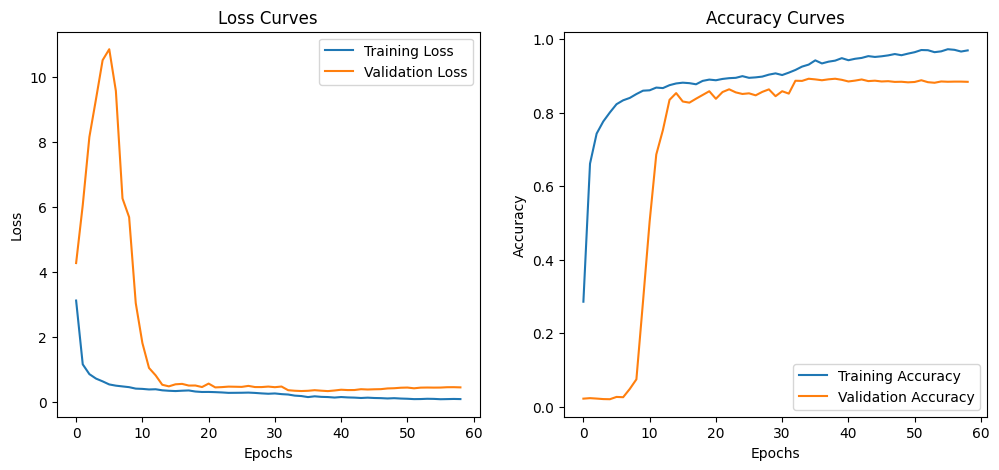

2/2 [==============================] - 0s 37ms/step - loss: 0.5532 - accuracy: 0.8867
Model Name:  model_9
Test Loss: 0.553
Test Accuracy: 0.887


: 

In [50]:
# 학습
model_path_model_ResNet50 = get_model_path(model_ResNet50.name)
early_stopping, model_checkpoint_cb = set_before_train(20, model_ResNet50.name)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # 성능을 모니터링할 지표
    factor=0.1,  # 학습률 감소 비율
    patience=10,  # 성능 향상이 없는 에포크 수
    min_lr=1e-6  # 학습률의 최소 값
)

with strategy.scope():
    start_time = time.time()
    history_model_ResNet50 = model_ResNet50.fit(train_dist_dataset, 
                               epochs=200, 
                               steps_per_epoch=train_steps_per_epoch,
                               validation_data=val_dist_dataset, 
                               validation_steps=val_steps_per_epoch,
                               callbacks=[early_stopping, model_checkpoint_cb, lr_scheduler])
    end_time = time.time()

model_ResNet50.save(model_path_model_ResNet50)
print("Training time : ", end_time - start_time)

# learning curve
plot_learning_curves(history_model_ResNet50)

# 테스트셋으로 성능 평가
test_loss_and_accuracy(model_ResNet50, X_test, batch_size, num_gpus, test_dist_dataset, custom_objects=None)